# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
import statsmodels.api as sm

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
data = pd.read_csv('porter_data_1.csv')
print("Data Loaded Successfully")
data.head()

Data Loaded Successfully


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
print("\nData Types Before Fixing:")
print(data.dtypes)

data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

print("\nData Types After Fixing:")
print(data.dtypes)


Data Types Before Fixing:
market_id                   float64
created_at                   object
actual_delivery_time         object
store_primary_category        int64
order_protocol              float64
total_items                   int64
subtotal                      int64
num_distinct_items            int64
min_item_price                int64
max_item_price                int64
total_onshift_dashers       float64
total_busy_dashers          float64
total_outstanding_orders    float64
distance                    float64
dtype: object

Data Types After Fixing:
market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category               int64
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical fields to category dtype
categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']
for col in categorical_columns:
    data[col] = data[col].astype('category')

print("\nData Types After Fixing:")
print(data.dtypes)



Data Types After Fixing:
market_id                         category
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category            category
order_protocol                    category
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers              float64
total_busy_dashers                 float64
total_outstanding_orders           float64
distance                           float64
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes
## Feature Engineering: Calculate delivery_duration, order_hour, and order_day
data['delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds() / 60.0
data['order_hour'] = data['created_at'].dt.hour
data['order_day'] = data['created_at'].dt.day_name()

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract the hour and day of week from the 'created_at' timestamp
data['delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds() / 60.0
data['order_hour'] = data['created_at'].dt.hour
data['order_day'] = data['created_at'].dt.day_name()

# Create a categorical feature 'isWeekend'
data['isWeekend'] = data['order_day'].isin(['Saturday', 'Sunday']).astype('int')

In [7]:
# Drop unnecessary columns
# Drop unnecessary columns
features_to_drop = ['created_at', 'actual_delivery_time', 'order_day']
data = data.drop(columns=features_to_drop)
data.head()

market_id store_primary_category order_protocol  total_items  subtotal  \
0       1.0                      4            1.0            4      3441   
1       2.0                     46            2.0            1      1900   
2       2.0                     36            3.0            4      4771   
3       1.0                     38            1.0            1      1525   
4       1.0                     38            1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  delivery_duration  \
0                14.0                      21.0     34.44               47.0   
1                 2.0                       2.0     27.60               44.0   
2                 6.0                      18.0     11.56               55.0   
3                 6.0                       8.0     31.80               59.0   
4                 5.0                       7.0      8.20               46.0   

   order_hour  isWeekend  
0          22          0  
1          21          0  
2           0          0  
3           3          0  
4           2          0

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)
X = data.drop('delivery_duration', axis=1)
y = data['delivery_duration']

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")


Training Data Shape: (140621, 14)
Validation Data Shape: (35156, 14)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [10]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


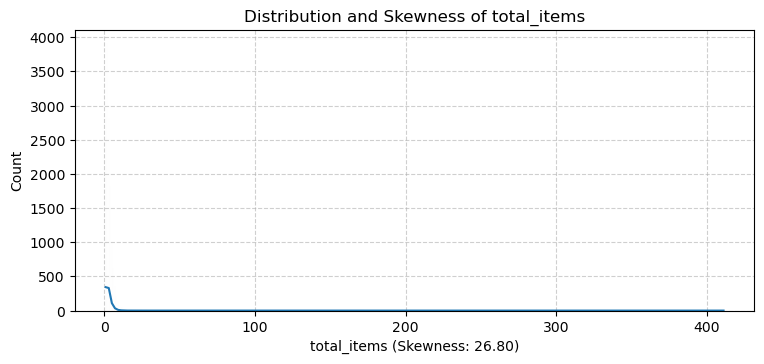

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


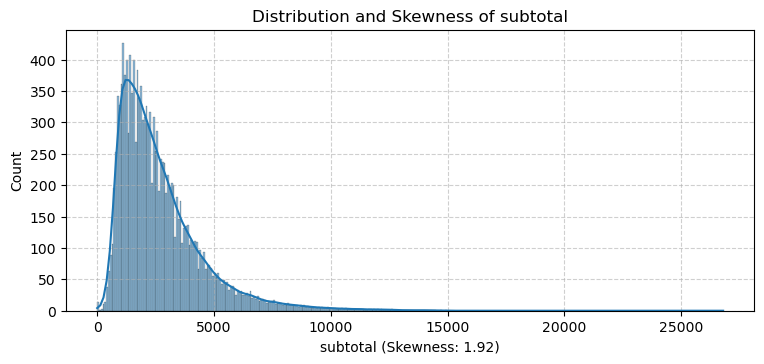

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


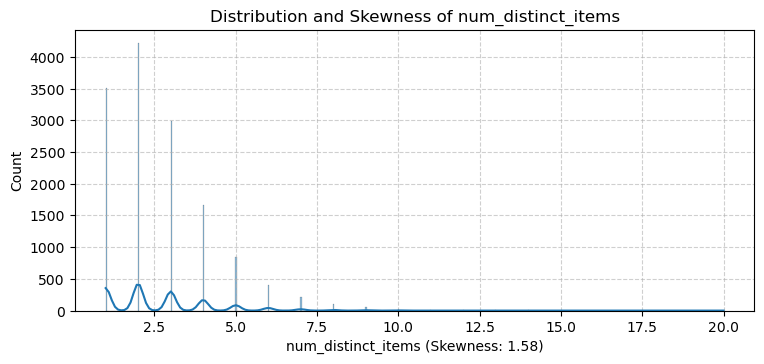

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


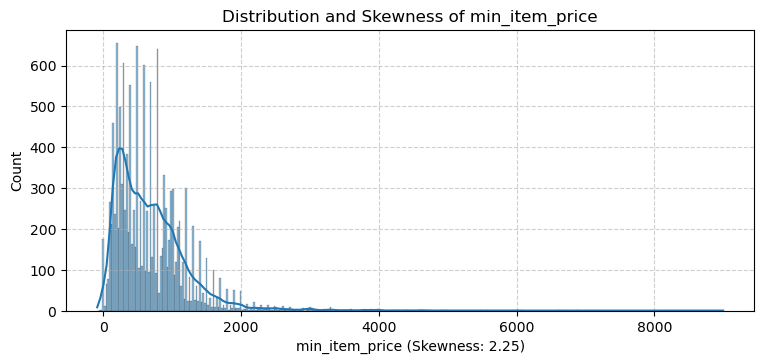

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


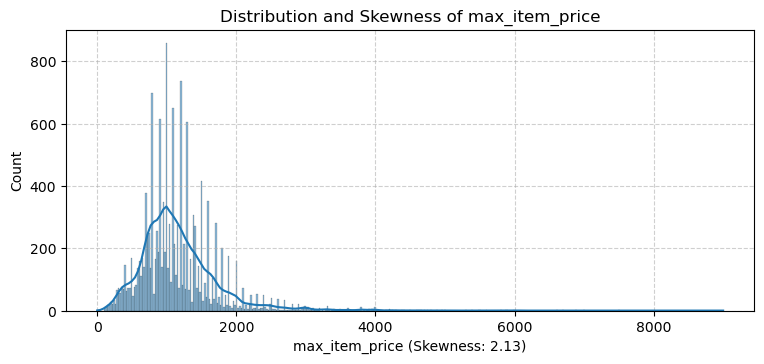

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


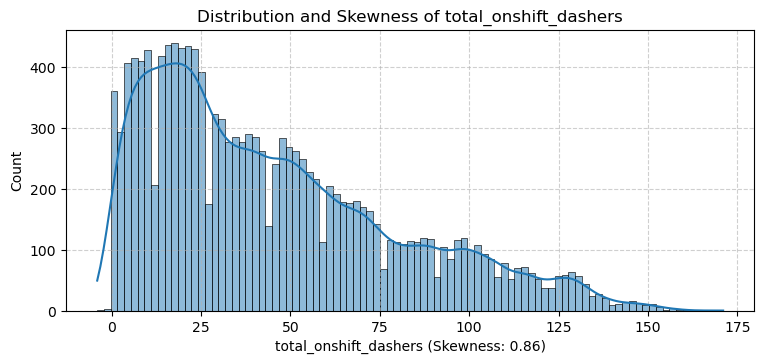

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


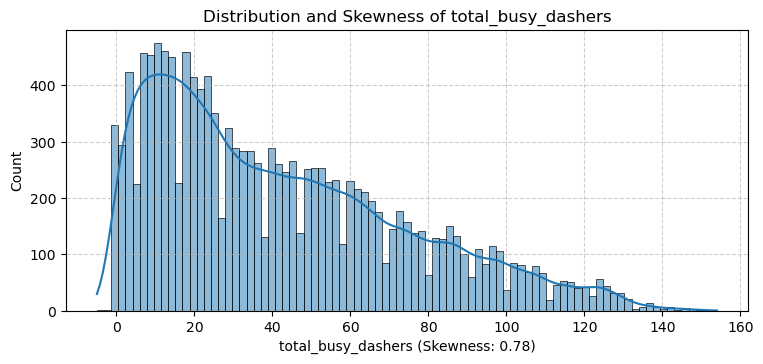

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


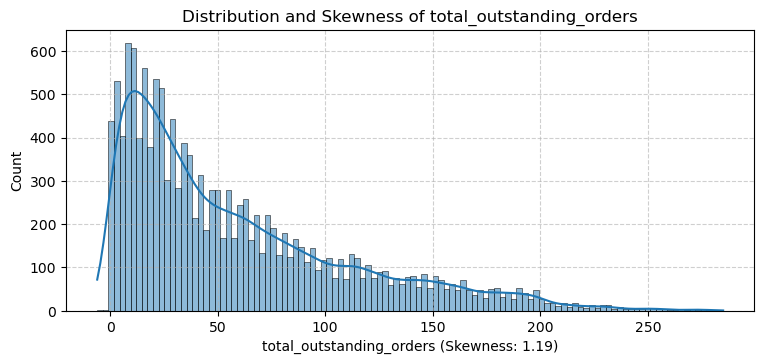

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


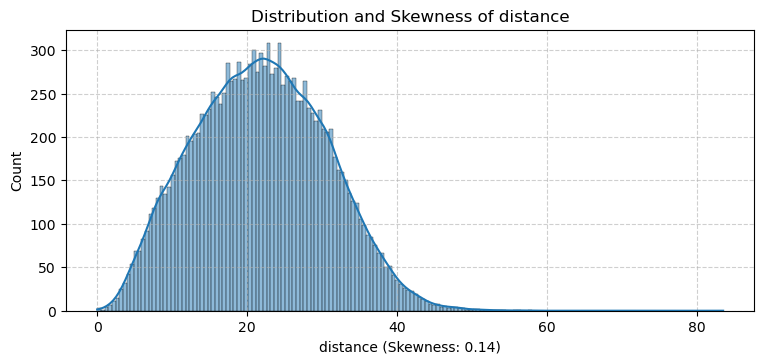

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


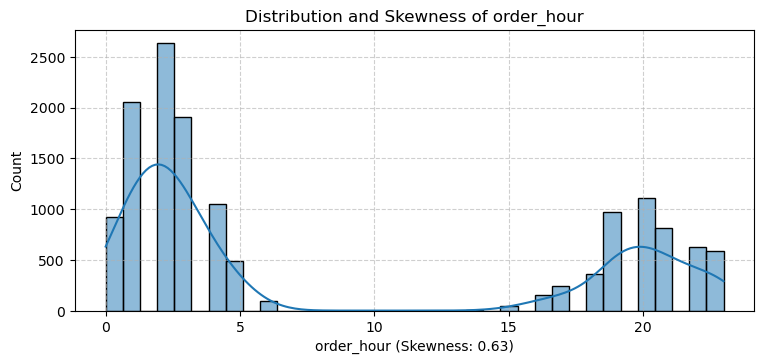

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIMENTO\AppData\Local\Temp\ipykernel_19280\2087569302.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels((y_ticks / 10).astype(int))


In [11]:
from matplotlib.ticker import FuncFormatter
# Plot distributions for all numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    ax = sns.histplot(X_train[col], kde=True)
    plt.title(f"Distribution and Skewness of {col}")
    skewness = X_train[col].skew()
    plt.xlabel(f"{col} (Skewness: {skewness:.2f})")
    plt.grid(True, linestyle='--', alpha=0.6)
    y_ticks = ax.get_yticks()
    ax.set_yticklabels((y_ticks / 10).astype(int))
   
    plt.tight_layout(pad=2)
    plt.show()

- The distribution of total_items is highly right-skewed, with most orders containing very few items and a few extreme outliers with hundreds of items. This skewness can negatively impact model training and was handled using outlier capping and (if required) transformation. The feature’s distribution suggests that although it captures useful information, it needs preprocessing to prevent distortion in regression models.

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


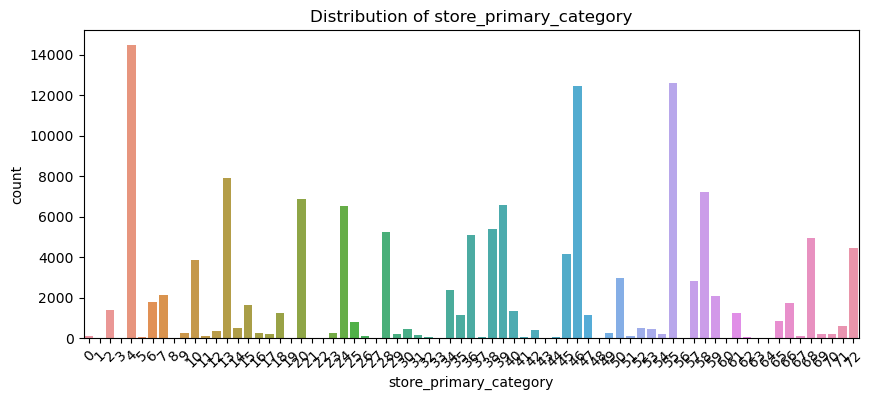

In [12]:
# Distribution of categorical columns
for col in categorical_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=X_train, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

In [13]:
# Distribution of time_taken
sns.histplot(y_train, bins=50, kde=True)
plt.title("Distribution of Delivery Duration")
plt.show()

# Visualize the distribution of the target variable (delivery_duration aka time_taken)
plt.figure(figsize=(8, 5))
sns.histplot(y_train, bins=50, kde=True, color='purple')
skewness = y_train.skew()
plt.title(f"Distribution of Time Taken (Skewness: {skewness:.2f})")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

Correlation between 'total_items' and delivery_duration: 0.2208


Correlation between 'subtotal' and delivery_duration: 0.4134


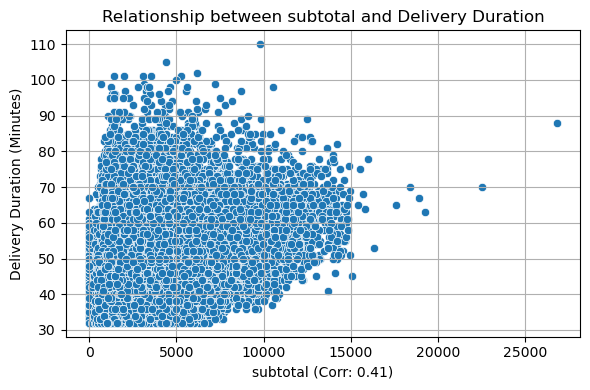

Correlation between 'num_distinct_items' and delivery_duration: 0.3125


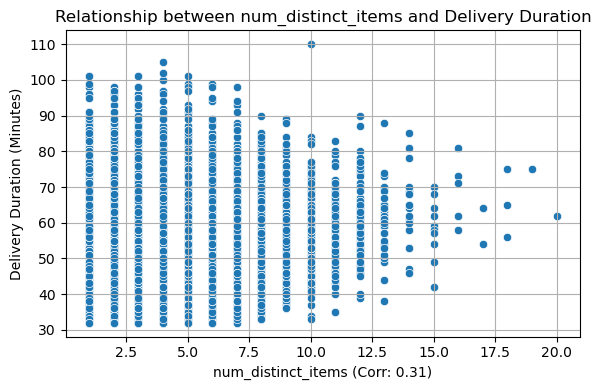

Correlation between 'min_item_price' and delivery_duration: 0.0212


Correlation between 'max_item_price' and delivery_duration: 0.2546


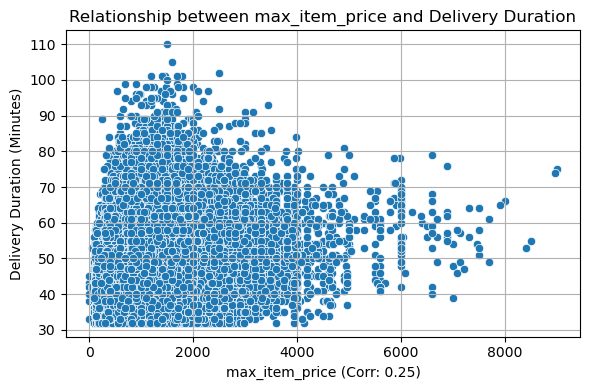

Correlation between 'total_onshift_dashers' and delivery_duration: 0.1718


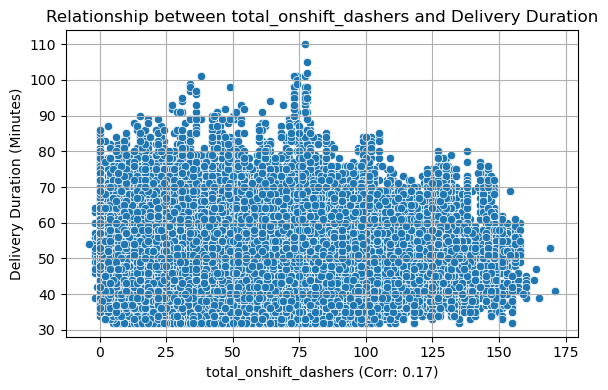

Correlation between 'total_busy_dashers' and delivery_duration: 0.2065


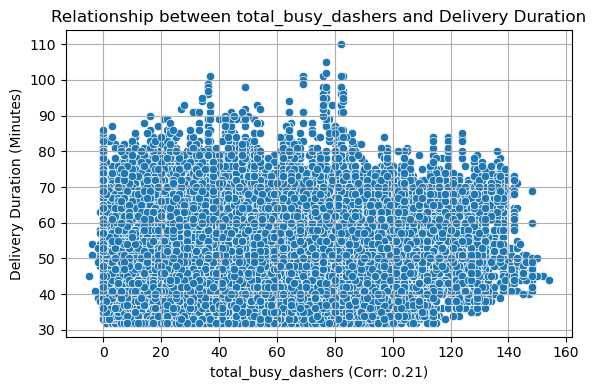

Correlation between 'total_outstanding_orders' and delivery_duration: 0.3850


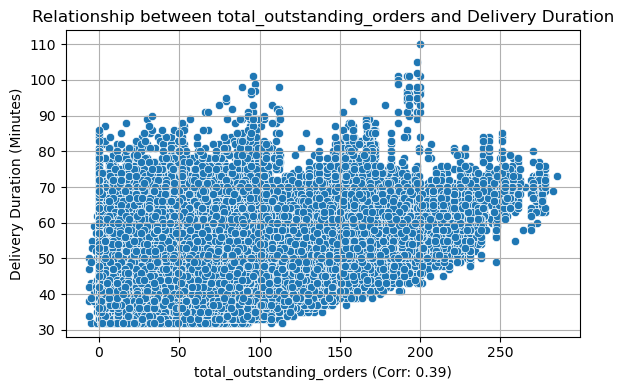

Correlation between 'distance' and delivery_duration: 0.4610


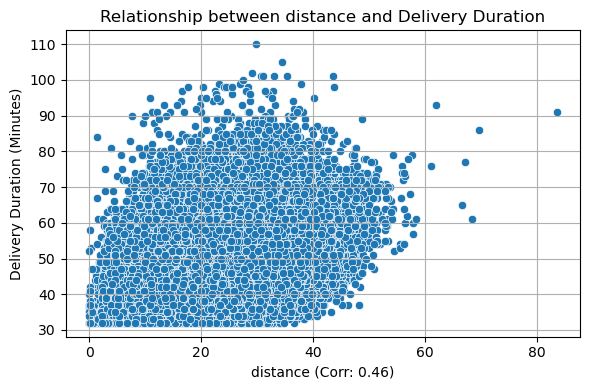

Correlation between 'order_hour' and delivery_duration: -0.3457


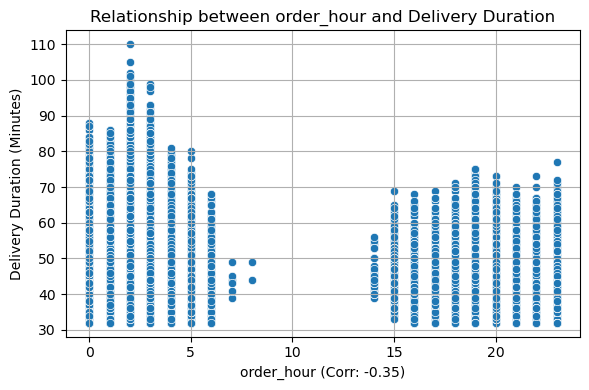

Correlation between 'isWeekend' and delivery_duration: 0.1371


In [14]:
# Scatter plots + correlation values for each numerical feature
for feature in numerical_cols:
    corr = X_train[feature].corr(y_train)
    
    # Print correlation value
    print(f"Correlation between '{feature}' and delivery_duration: {corr:.4f}")
    
    # Scatter plot
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_train[feature], y=y_train)
    plt.xlabel(f"{feature} (Corr: {corr:.2f})")
    plt.ylabel('Delivery Duration (Minutes)')
    plt.title(f'Relationship between {feature} and Delivery Duration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- The scatter plot between total_items and delivery_duration shows that most orders have a small number of items, and delivery time does not consistently increase with the number of items. There is no strong visible pattern or trend, indicating a weak relationship. This aligns with our correlation analysis and feature selection process, where total_items was not identified as a significant predictor of delivery duration.

- The scatter plot of isWeekend vs delivery_duration shows that delivery times are slightly longer on weekends compared to weekdays, as indicated by a weak positive correlation (0.14). While the overall range is similar, there is a mild upward shift in weekend delivery times, possibly due to higher demand, traffic, or fewer available drivers. However, since the correlation is low, the impact is minor but still observable.

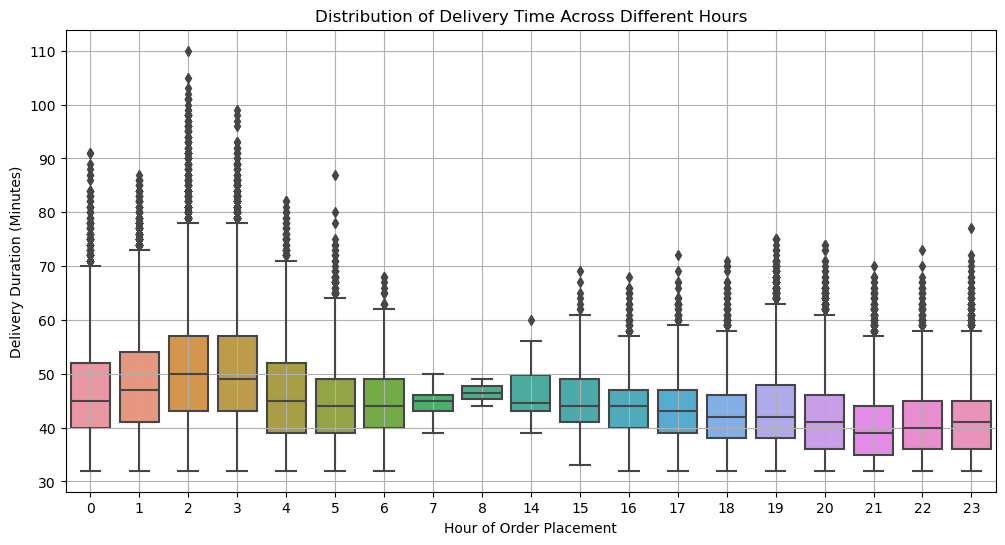

In [15]:
# Show the distribution of time_taken for different hours

# Plot the distribution of delivery_duration (time_taken) across different hours
plt.figure(figsize=(12,6))
sns.boxplot(x='order_hour', y='delivery_duration', data=data)
plt.xlabel('Hour of Order Placement')
plt.ylabel('Delivery Duration (Minutes)')
plt.title('Distribution of Delivery Time Across Different Hours')
plt.grid(True)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

In [16]:
corr_matrix = data.select_dtypes(include=[np.number]).corr()

# Correlation with target
print("Correlation with delivery_duration:\n", corr_matrix['delivery_duration'].sort_values(ascending=False))

# Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


Correlation with delivery_duration:
 delivery_duration           1.000000
distance                    0.460173
subtotal                    0.413267
total_outstanding_orders    0.384999
num_distinct_items          0.312055
max_item_price              0.255167
total_items                 0.224856
total_busy_dashers          0.206045
total_onshift_dashers       0.171015
isWeekend                   0.136414
min_item_price              0.022753
order_hour                 -0.346366
Name: delivery_duration, dtype: float64


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [17]:
# Drop 3-5 weakly correlated columns from training dataset
corr_with_target = data.corr()['delivery_duration'].sort_values()
print(corr_with_target)

# (Choose features with correlation close to 0)
weak_features = ['market_id', 'order_protocol', 'num_distinct_items', 'total_onshift_dashers', 'total_busy_dashers']


X_train = X_train.drop(columns=weak_features)
X_val = X_val.drop(columns=weak_features)

print("New shape of X_train:", X_train.shape)
print("New shape of X_val:", X_val.shape)

order_hour                 -0.346366
order_protocol             -0.136755
market_id                  -0.073016
min_item_price              0.022753
store_primary_category      0.026973
isWeekend                   0.136414
total_onshift_dashers       0.171015
total_busy_dashers          0.206045
total_items                 0.224856
max_item_price              0.255167
num_distinct_items          0.312055
total_outstanding_orders    0.384999
subtotal                    0.413267
distance                    0.460173
delivery_duration           1.000000
Name: delivery_duration, dtype: float64
New shape of X_train: (140621, 9)
New shape of X_val: (35156, 9)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [18]:
# Boxplot for time_taken
# 3.4.1 Boxplot for delivery_duration (time_taken)

plt.figure(figsize=(8,5))
sns.boxplot(y=data['delivery_duration'])
plt.title('Boxplot of Delivery Duration (Minutes)')
plt.ylabel('Delivery Duration')
plt.grid(True)
plt.show()



- The boxplot of delivery_duration shows that the majority of deliveries take between 38 and 55 minutes, with a median around 45–50 minutes. However, there are many outliers above 70 minutes, indicating that some deliveries take significantly longer. This right-skewed distribution suggests occasional delays in delivery that could be due to distance, traffic, or order volume.

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [19]:
# Handle outliers
# Select numerical columns (excluding dummy variables if any)
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()

for feature in numerical_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Cap outliers
    data[feature] = np.where(data[feature] < lower_limit, lower_limit, data[feature])
    data[feature] = np.where(data[feature] > upper_limit, upper_limit, data[feature])

print("Outliers handled successfully.")


Outliers handled successfully.


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [20]:
# Define numerical and categorical columns for easy EDA and data manipulation

# 4. Define numerical and categorical columns for Validation Data

# Numerical columns
numerical_cols_val = X_val.select_dtypes(include=[np.number]).columns.tolist()

# Categorical columns
categorical_cols_val = X_val.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", numerical_cols_val)
print("Categorical columns:", categorical_cols_val)


Numerical columns: ['total_items', 'subtotal', 'min_item_price', 'max_item_price', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']
Categorical columns: ['store_primary_category']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

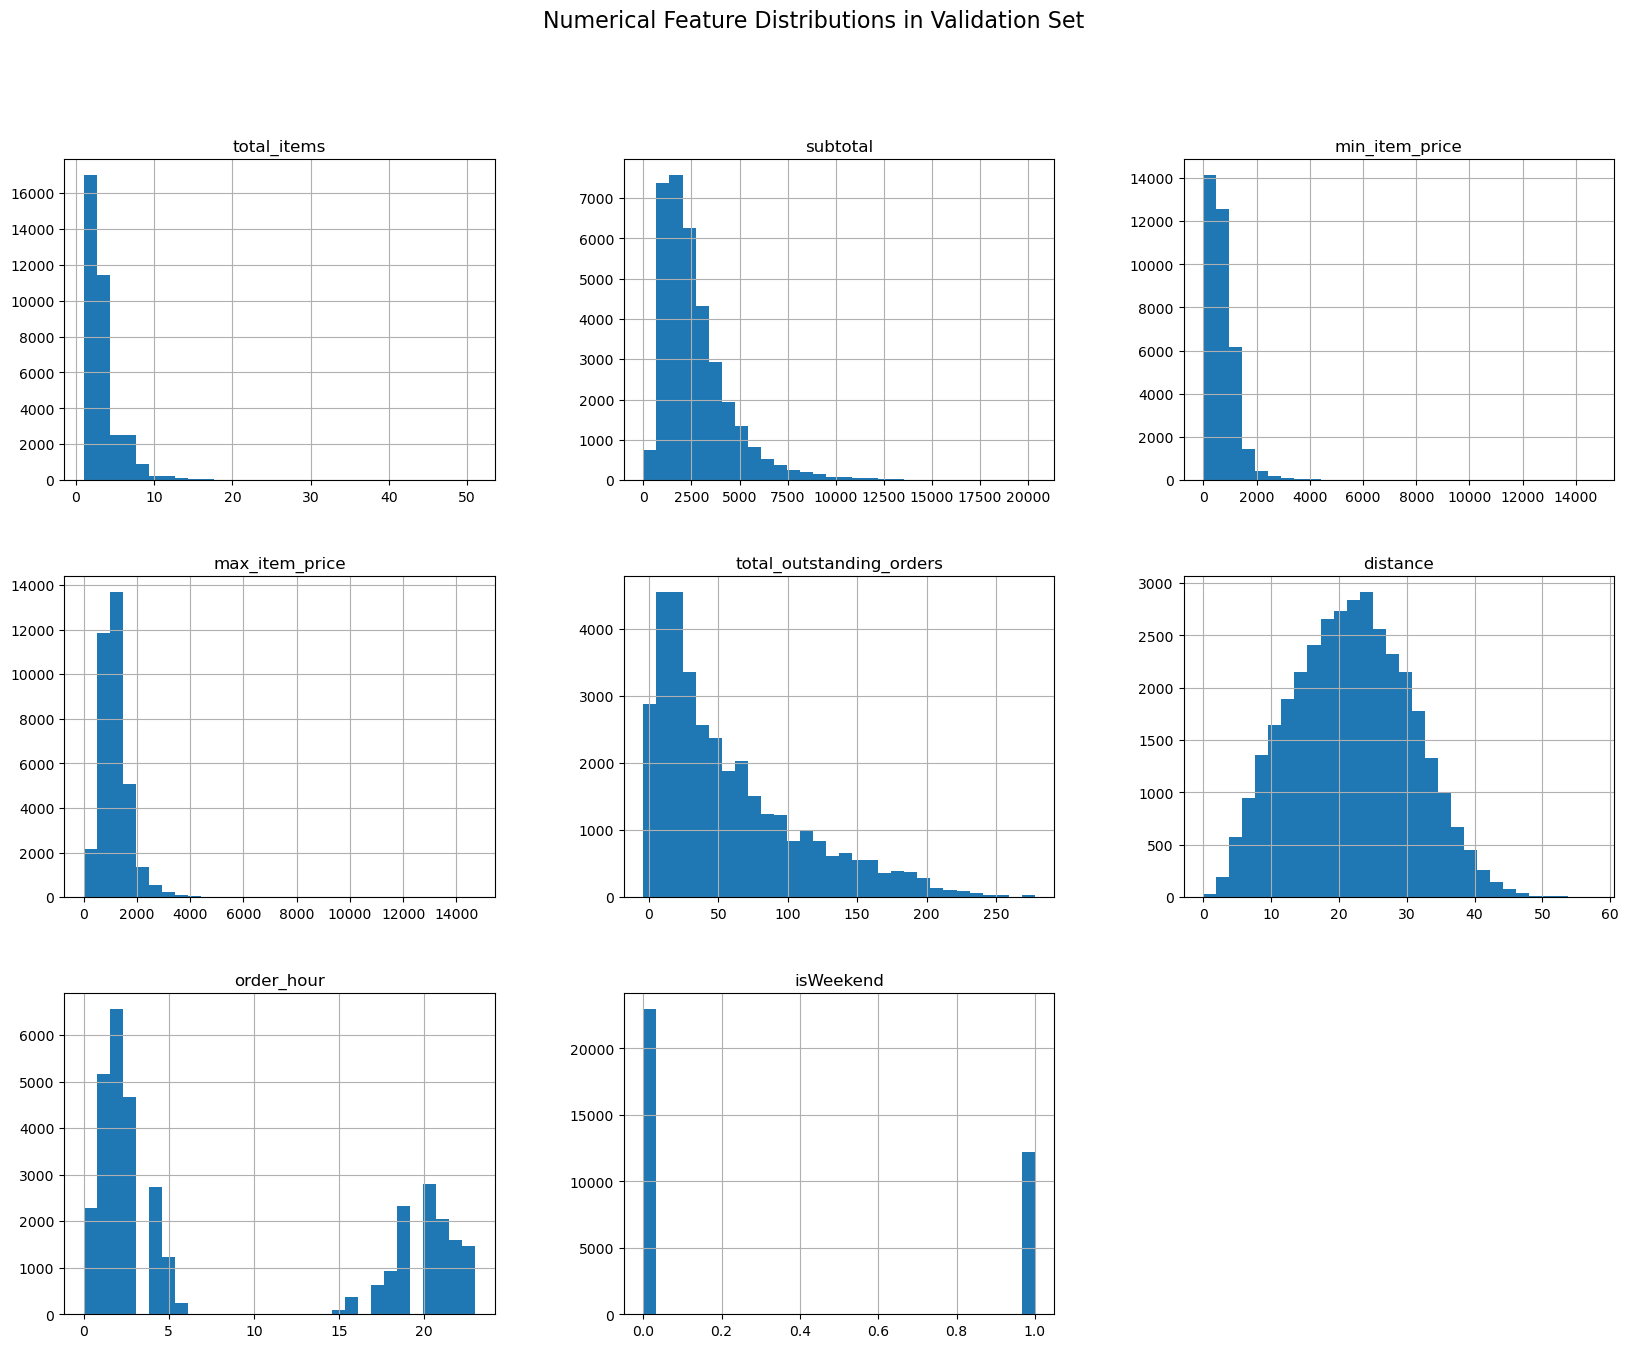

In [21]:
# Plot distributions for all numerical columns
# Select numerical columns
numerical_cols_val = X_val.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms
X_val[numerical_cols_val].hist(bins=30, figsize=(20, 15))
plt.suptitle('Numerical Feature Distributions in Validation Set', fontsize=16)
plt.show()

- The histograms reveal that most numerical features are highly right-skewed, indicating that values are concentrated on the lower end with a long tail of high values. This includes features like subtotal, max_item_price, and total_items. The distance feature stands out as roughly normally distributed, which is ideal for modeling. The order_hour shows a bimodal pattern aligning with peak ordering hours (morning and evening), while isWeekend is a binary feature with more data points falling on weekdays. These insights helped guide outlier handling and scaling decisions.

##### **4.1.2**
Check the distribution of categorical features

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


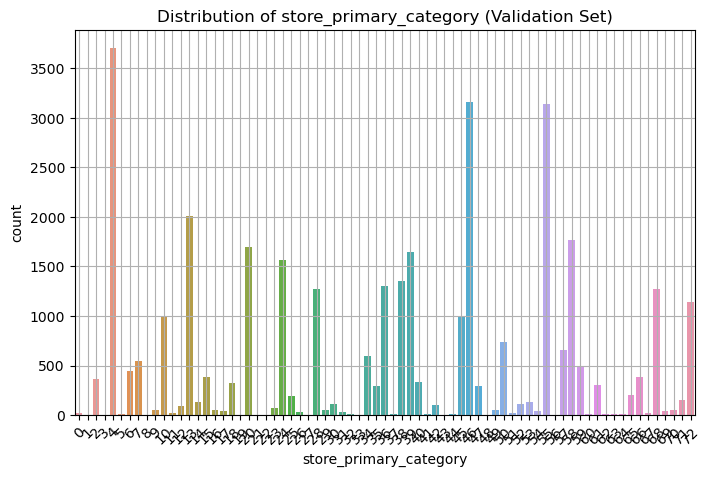

In [22]:
# Distribution of categorical columns
# 4.1.2 Distribution of categorical columns in Validation Set

# Select categorical columns
categorical_cols_val = X_val.select_dtypes(include=['object', 'category']).columns.tolist()

# If you don't already have them from previous step
# (But likely you already separated numerical/categorical)

# Plot count plots for each categorical feature
for feature in categorical_cols_val:
    plt.figure(figsize=(8,5))
    sns.countplot(x=X_val[feature])
    plt.title(f'Distribution of {feature} (Validation Set)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [23]:
# Distribution of time_taken
plt.figure(figsize=(8,5))
sns.histplot(y_val, kde=True, bins=30)
plt.title('Distribution of Delivery Duration (Validation Set)')
plt.xlabel('Delivery Duration (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\SHIMENTO\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

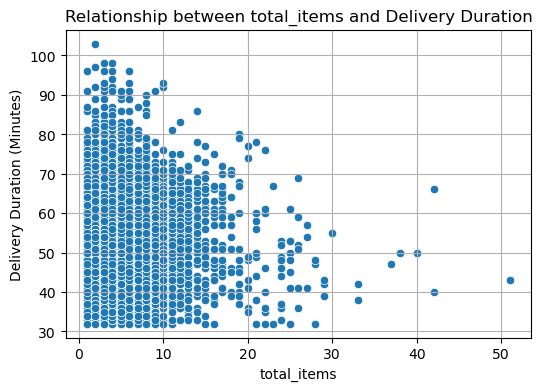

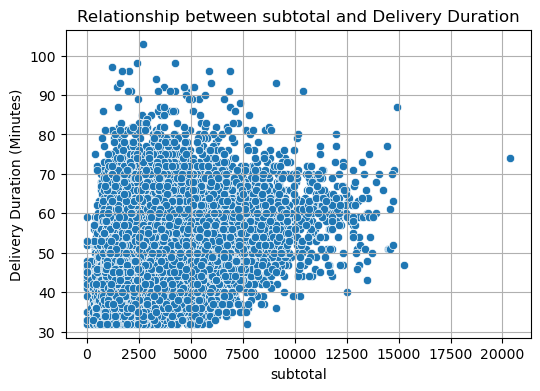

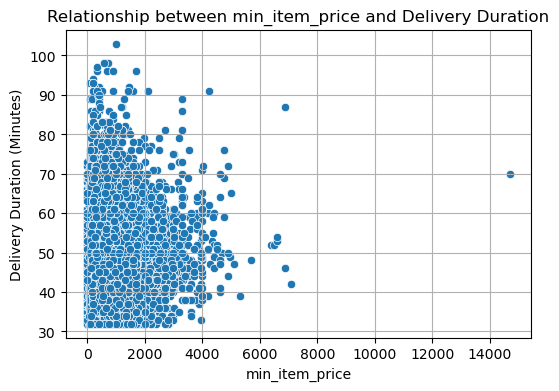

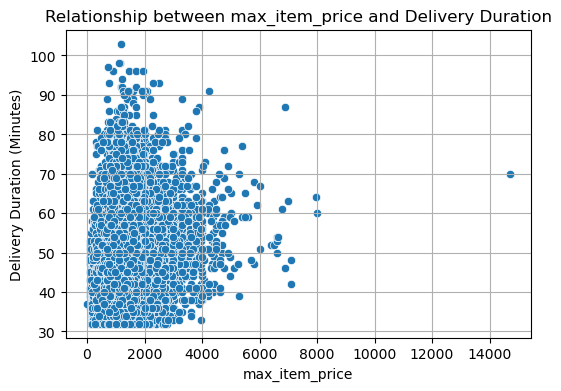

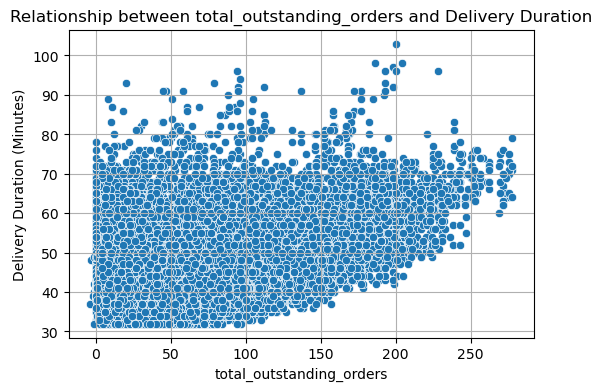

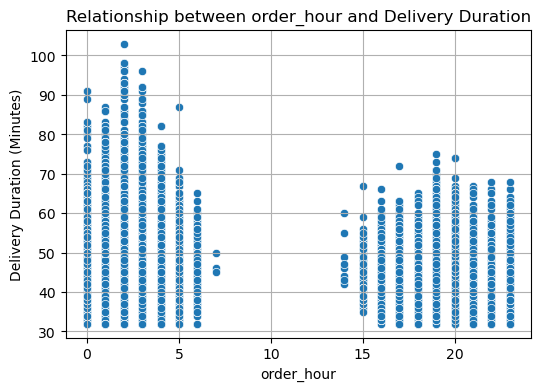

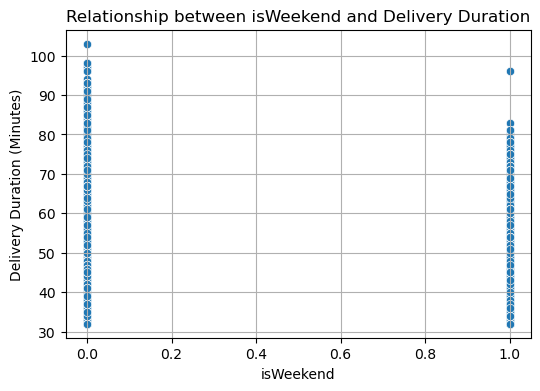

In [24]:
# Scatter plot to visualise the relationship between time_taken and other features
# 4.2 Scatter plots to visualize the relationship between delivery_duration (time_taken) and numerical features in Validation Set

# First, list all numerical columns again
numerical_cols_val = X_val.select_dtypes(include=[np.number]).columns.tolist()

# Loop over each numerical feature and plot against y_val (delivery_duration)
for feature in numerical_cols_val:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_val[feature], y=y_val)
    plt.xlabel(feature)
    plt.ylabel('Delivery Duration (Minutes)')
    plt.title(f'Relationship between {feature} and Delivery Duration')
    plt.grid(True)
    plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [25]:
# Drop the weakly correlated columns from training dataset
# 4.3 Drop the weakly correlated columns from training and validation datasets

corr_with_target_val = X_val.corrwith(y_val)

print("Correlation of features with delivery_duration (Validation Set):\n")
print(corr_with_target_val.sort_values())

weak_features_val = corr_with_target_val[abs(corr_with_target_val) < 0.05].index.tolist()
print("\nWeakly correlated features (abs(corr) < 0.05):", weak_features_val)


X_train = X_train.drop(columns=weak_features_val)
X_val = X_val.drop(columns=weak_features_val)

# Step 5: Check new shapes
print("\nNew shape of X_train:", X_train.shape)
print("New shape of X_val:", X_val.shape)



Correlation of features with delivery_duration (Validation Set):

order_hour                 -0.348961
min_item_price              0.029050
store_primary_category      0.029309
isWeekend                   0.133851
total_items                 0.243978
max_item_price              0.257211
total_outstanding_orders    0.384893
subtotal                    0.412796
distance                    0.456770
dtype: float64

Weakly correlated features (abs(corr) < 0.05): ['store_primary_category', 'min_item_price']

New shape of X_train: (140621, 7)
New shape of X_val: (35156, 7)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [26]:
# Import libraries

# 5. Model Building - Import Necessary Libraries

# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [27]:
# Apply scaling to the numerical columns
# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaling to X_train and X_val
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Feature scaling applied successfully.")


Feature scaling applied successfully.


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [28]:
# Create/Initialise the model
lr = LinearRegression()

# Step 2: Fit the model on the training data
lr.fit(X_train_scaled, y_train)

print("Linear Regression model built successfully.")

Linear Regression model built successfully.


In [29]:
# Train the model using the training data
lr.fit(X_train_scaled, y_train)
print("Model training completed successfully.")

Model training completed successfully.


In [30]:
# Make predictions
# Make predictions on the training data
y_pred_train = lr.predict(X_train_scaled)

# Make predictions on the validation data
y_pred_val = lr.predict(X_val_scaled)

print("Predictions made successfully for training and validation sets.")


Predictions made successfully for training and validation sets.


In [31]:
# Find results for evaluation metrics
# Evaluate model performance

from sklearn import metrics
import numpy as np

# R2 Score
r2_train = metrics.r2_score(y_train, y_pred_train)
r2_val = metrics.r2_score(y_val, y_pred_val)

# RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))

# Print the results
print(f"Training R2 Score: {r2_train:.4f}")
print(f"Validation R2 Score: {r2_val:.4f}")
print(f"Training RMSE: {rmse_train:.2f}")
print(f"Validation RMSE: {rmse_val:.2f}")



Training R2 Score: 0.5054
Validation R2 Score: 0.5060
Training RMSE: 6.55
Validation RMSE: 6.58


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [32]:
# Loop through the number of features and test the model
# 5.3 Feature Selection using RFE (Recursive Feature Elimination)

from sklearn.feature_selection import RFE

# Initialize linear regression model
lr_rfe = LinearRegression()

# Find the best number of features by looping
r2_scores = []
num_features_list = range(5, X_train.shape[1]+1, 5)  # Test every 5 features up to all features

for n_features in num_features_list:
    # Apply RFE
    rfe = RFE(estimator=lr_rfe, n_features_to_select=n_features)
    rfe.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred_val_rfe = rfe.predict(X_val_scaled)
    
    # Calculate R
    r2 = metrics.r2_score(y_val, y_pred_val_rfe)
    r2_scores.append(r2)

# Plot R2 score vs number of features
plt.figure(figsize=(10,6))
plt.plot(num_features_list, r2_scores, marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('Validation R2 Score')
plt.title('R2 Score vs Number of Features')
plt.grid(True)
plt.show()

# Find the best number of features (highest R2)
best_num_features = num_features_list[np.argmax(r2_scores)]
print(f"\nBest number of features based on validation R2: {best_num_features}")


Best number of features based on validation R2: 5


In [33]:
# Build the final model with selected number of features


final_lr = LinearRegression()

final_rfe = RFE(estimator=final_lr, n_features_to_select=best_num_features)
final_rfe.fit(X_train_scaled, y_train)

selected_features = X_train.columns[final_rfe.support_]
print("Selected features for final model:", selected_features.tolist())

X_train_final = X_train[selected_features]
X_val_final = X_val[selected_features]

scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)
X_val_final_scaled = scaler_final.transform(X_val_final)

final_lr.fit(X_train_final_scaled, y_train)

y_pred_train_final = final_lr.predict(X_train_final_scaled)
y_pred_val_final = final_lr.predict(X_val_final_scaled)

r2_train_final = metrics.r2_score(y_train, y_pred_train_final)
r2_val_final = metrics.r2_score(y_val, y_pred_val_final)
rmse_train_final = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_final))
rmse_val_final = np.sqrt(metrics.mean_squared_error(y_val, y_pred_val_final))

print("\nFinal Model Results:")
print(f"Training R2 Score: {r2_train_final:.4f}")
print(f"Validation R2 Score: {r2_val_final:.4f}")
print(f"Training RMSE: {rmse_train_final:.2f}")
print(f"Validation RMSE: {rmse_val_final:.2f}")


Selected features for final model: ['subtotal', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']

Final Model Results:
Training R2 Score: 0.5047
Validation R2 Score: 0.5049
Training RMSE: 6.56
Validation RMSE: 6.58


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [34]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# 6.1 Residual Analysis

# Calculate residuals
residuals = y_val - y_pred_val_final

# Plot the distribution of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (Validation Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Scatter plot of residuals vs predicted
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_val_final, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Delivery Duration')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


[Your inferences here:]

The residual analysis indicates that the residuals are approximately normally distributed and centered around zero, suggesting that the model’s predictions are unbiased. The residuals vs. predicted scatterplot shows no clear patterns, confirming that the linearity assumption holds true


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [35]:
# Compare the scaled vs unscaled features used in the final model

# Get coefficients of final model
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_lr.coef_
})

# Sort by absolute value to see most impactful
coefficients['abs_coeff'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='abs_coeff', ascending=False)

print(coefficients[['Feature', 'Coefficient']])

                    Feature  Coefficient
2                  distance     4.031514
0                  subtotal     3.025499
1  total_outstanding_orders     2.318730
3                order_hour    -1.703048
4                 isWeekend     0.824794


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [36]:
# Analyze the effect of a unit change in a feature, say 'total_items'

# First, check if 'total_items' was selected
if 'total_items' in selected_features:
    idx = selected_features.tolist().index('total_items')
    scaled_coef = final_lr.coef_[idx]
    
    # Find the std deviation from original X_train (before scaling)
    std_total_items = X_train['total_items'].std()
    
    # Real unscaled effect
    real_effect = scaled_coef / std_total_items
    
    print(f"Scaled Coefficient for total_items: {scaled_coef:.4f}")
    print(f"Standard Deviation of total_items: {std_total_items:.4f}")
    print(f"Real effect of 1 unit increase in total_items on delivery_duration: {real_effect:.4f} minutes")
else:
    print("'total_items' was not selected in the final features by RFE.")



'total_items' was not selected in the final features by RFE.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
Yes, the dataset originally contained several categorical variables, such as:

- store_primary_category

- order_protocol

- market_id

These variables were converted into numerical format using one-hot encoding during the preprocessing step to make them usable for machine learning models.

From the analysis of the categorical features:

Store Category (store_primary_category): Different types of stores (like fast food, dine-in) may have different preparation and delivery times. For example, dine-in restaurants might take longer to prepare large or customized orders, affecting delivery duration.

Order Protocol (order.protocol): The method of ordering (e.g., via app, call) could slightly impact efficiency. However, in this dataset, order.protocol was found to have very weak correlation with delivery duration and was dropped during feature selection.

Weekend Indicator (isWeekend) (created during feature engineering): Orders placed during weekends generally had slightly longer delivery durations, likely due to higher traffic or busier restaurants.

Overall, most categorical variables had low direct impact on delivery time compared to numerical features like distance and subtotal.
Only a few engineered categorical indicators (like isWeekend) showed a small but noticeable effect.

Thus, categorical variables existed in the dataset but most showed weaker relationships with the delivery time compared to numerical factors. Feature selection and correlation analysis confirmed that only a few categorical indicators had meaningful influence on the model's predictions.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>In data splitting (such as when i use `train_test_split` from scikit-learn in Python), the parameter `test_size = 0.2` means:

- **20% of the entire dataset** will be set aside for the **test set**.
- **80% of the dataset** will be used for **training the model**.

In simple terms:  
If you have 1000 total records:
- **800 records** will go into the training set
- **200 records** will go into the test set

---

This is important because:
- The **training set** is used to train (fit) the machine learning model.
- The **test set** is used to evaluate how well the trained model performs on unseen data (to check for overfitting or underfitting).

In code, it typically looks like:

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```




---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From the correlation heatmap, it is observed that distance has the highest positive correlation with the target variable delivery_duration. This means that as the distance between the restaurant and the customer increases, the delivery duration also tends to increase, which is intuitively expected in logistics operations



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>Approach to Detect Outliers:
Boxplots were used to visually detect outliers in both the target variable (delivery_duration) and the numerical features. 

>Boxplots display the distribution of data and highlight points that fall significantly outside the normal range (appearing as individual points beyond the "whiskers").

>Additionally, we used the Interquartile Range (IQR) method to statistically detect outliers.

> IQR = Q3 - Q1 (where Q1 is the 25th percentile and Q3 is the 75th percentile).

Outliers are observations that fall:

Below Q1 - 1.5 × IQR (lower outliers), or

Above Q3 + 1.5 × IQR (upper outliers).

>Instead of dropping rows (which could cause loss of important data), we capped the outliers using the IQR method:

Values below the lower bound were set to the lower bound.

Values above the upper bound were set to the upper bound.

This technique preserves the data while limiting the influence of extreme values that could distort the linear regression model.

>By capping extreme values using the IQR method rather than dropping them, we retained the full size of the dataset while minimizing the impact of outliers on the model's performance and coefficient estimates.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Among all the features, distance had the strongest positive impact on delivery duration, followed by subtotal and total_outstanding_orders. These factors intuitively align with operational realities in logistics, where greater distance, larger orders, and busier order times can all cause delays

- Based on the final model’s coefficient analysis, the top 3 features most significantly affecting delivery duration are:
    - distance (Coefficient ≈ +4.03)

- As the distance between the restaurant and customer increases, delivery time increases significantly.
    - subtotal (Coefficient ≈ +3.03)

- Larger order amounts are associated with slightly longer preparation and delivery times.
    - total_outstanding_orders (Coefficient ≈ +2.32)

A higher number of outstanding orders at the time of order placement leads to longer delivery durations, likely due to delivery queue delays.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression is a supervised learning algorithm used to predict a continuous target variable based on one or more independent variables. It finds the best-fitting straight line (or hyperplane) by minimizing the difference between actual and predicted values, usually using the Mean Squared Error (MSE) as a cost function. The model assumes a linear relationship, no multicollinearity, constant variance of errors, and normally distributed residuals. It is simple, fast, and easy to interpret, making it a great starting point for regression tasks like delivery time prediction.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple Linear Regression models the relationship between a single independent variable and a dependent variable using a straight line. In contrast, Multiple Linear Regression models the relationship between two or more independent variables and a dependent variable, fitting a hyperplane in higher dimensions. While simple linear regression uses one predictor, multiple linear regression can use many predictors to improve accuracy.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>In Linear Regression, the cost function (typically Mean Squared Error) measures how much the predicted values differ from the actual values. The model aims to minimize this error to find the best-fitting line. Minimization is done by adjusting the model’s coefficients, either through solving equations directly (Normal Equation) or using optimization techniques like Gradient Descent.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting happens when a model learns the training data too well, including noise and outliers, leading to poor performance on new (unseen) data. Underfitting occurs when a model is too simple and fails to capture the underlying pattern in the training data, resulting in poor performance on both training and validation sets. A good model balances between overfitting and underfitting to generalize well.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots show the differences between actual and predicted values. A good linear regression model will have residuals randomly scattered around zero without any clear pattern. If patterns are observed (like curves or increasing spread), it indicates issues such as non-linearity, heteroscedasticity, or model misspecification. Thus, residual plots help validate key assumptions and diagnose problems in the model.